In [ ]:
pip install visualkeras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import visualkeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pydot
import graphviz
from PIL import Image

Importing training and test datasets



In [ ]:
test_df = pd.read_csv('/content/Data Sources/fashion-mnist_test.csv')
train_df = pd.read_csv('/content/Data Sources/fashion-mnist_train.csv')

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


Storing the labels in a dictionary



In [ ]:
classes = {0 : 'T-shirt/top',
1 :  'Trouser',
2 : 'Pullover',
3 : 'Dress',
4 : 'Coat',
5 : 'Sandal',
6 : 'Shirt',
7 : 'Sneaker',
8 : 'Bag',
9 : 'Ankle boot'}

Let's map these classes to the training and test dataframes to visualize the distribution of different labels



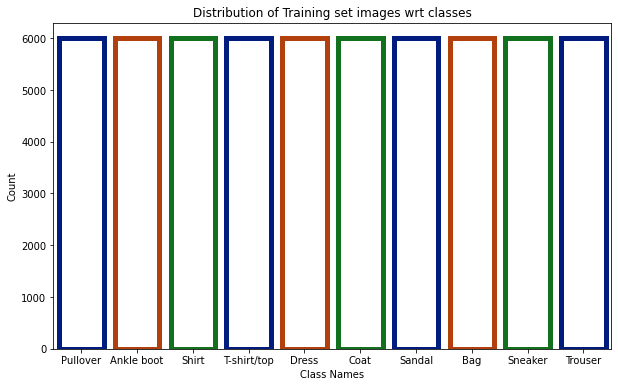

In [ ]:
train_df['label_names'] = train_df['label'].map(classes)

plt.figure(figsize=(10,6))
sns.countplot(x = 'label_names', data = train_df, facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))
plt.xlabel('Class Names')
plt.ylabel('Count')
plt.title('Distribution of Training set images wrt classes')
plt.show()

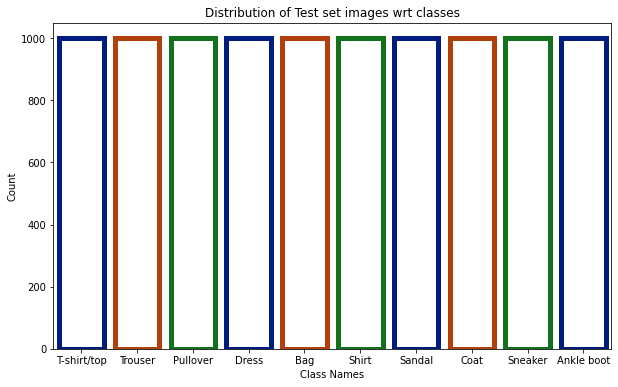

In [ ]:
test_df['label_names'] = test_df['label'].map(classes)

plt.figure(figsize=(10,6))
sns.countplot(x = 'label_names', data = test_df, facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))
plt.xlabel('Class Names')
plt.ylabel('Count')
plt.title('Distribution of Test set images wrt classes')
plt.show()

Let's see the shape of training and test set.



In [ ]:
train_df.shape

(60000, 786)

In [ ]:
test_df.shape

(10000, 786)

Let's prepare our data for preprocessing. First, we're going to divide training and test sets into features and labels.



In [ ]:
X_train = train_df.drop(['label', 'label_names'], axis = 1)
y_train = train_df.label

In [ ]:
X_test = test_df.drop(['label', 'label_names'], axis = 1)
y_test = test_df.label

Now we're going to reshape our images



In [ ]:
X_train = X_train.values.reshape(X_train.shape[0], 28, 28)
X_test = X_test.values.reshape(X_test.shape[0], 28, 28)

Let's check the shapes again



In [ ]:
X_train.shape


(60000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

Let's visualize a single image from our training set



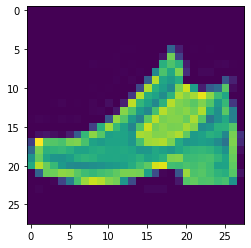

In [ ]:
single_image = X_train[1]
plt.imshow(single_image)

This looks like an ankle boot to me. Let's check the labels to confirm it

In [ ]:
y_train

0        2
1        9
2        6
3        0
4        3
        ..
59995    9
59996    1
59997    8
59998    8
59999    7
Name: label, Length: 60000, dtype: int64

Index 1 has 9 as a value which is the key of Ankle boot as per classes dictionary, so we stand correct

OK, now back to data preprocessing. We're gonna convert our data from class vector to a binary matrix. So, we're gonna use Keras's to_categorical method to convert our labels into one-hot vectors.

In [ ]:
y_cat_train = to_categorical(y_train, num_classes= 10)
y_cat_test = to_categorical(y_test, num_classes= 10)

to_categorical takes number of classes on its own based on the label's unique values, here it was from 0 to 9, hence, it took 10. You can specify them too, like I did using num_classes

Let's check a single example from our training set, how it looks like

In [ ]:
y_cat_train[0]


array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Notice here, the first value of y_train was 2(check the cell below the ankle boot image), so to_categorical() has transformed that into an entire row. So, now at index no. 2, we have 1 and all the other values are 0.

Now we're going to normalize our images. Right now the pixel values ranges from 0 to 255, where 255 represents the lighest colour cell and 0 represents the darkest colour cell. We're gonna convert them into the values from 0 to 1.

I'm going to visualize that Ankle shoe image in the form of pixels now

In [ ]:
def plot_digit(digit, dem = 28, font_size = 12):
    max_ax = font_size * dem
    
    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black = '#000000'
    
    for idx in range(dem):
        for jdx in range(dem):

            t = plt.text(idx * font_size, max_ax - jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black)
            c = digit[jdx][idx] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))
            
    plt.show()

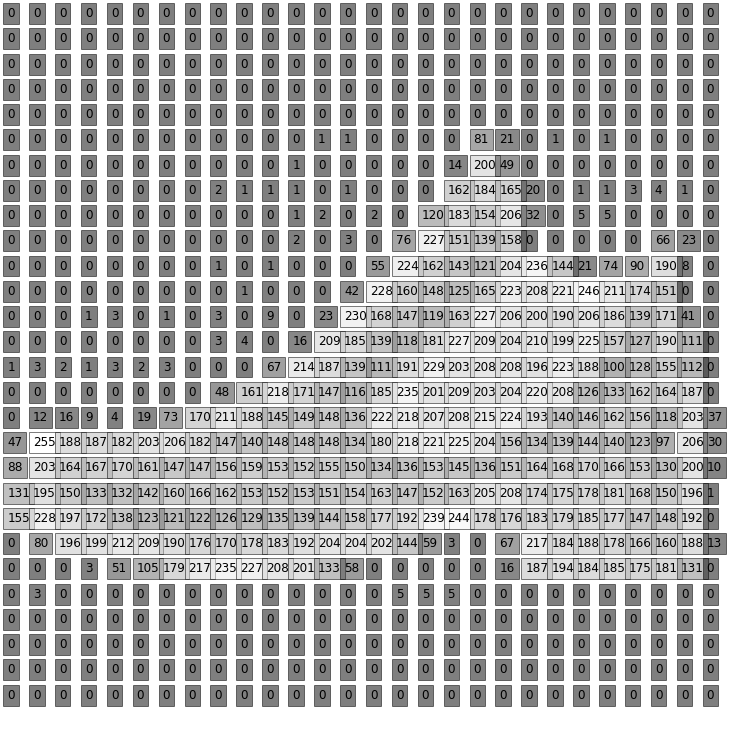

In [ ]:
plot_digit(X_train[1])

We can normalize/scale the image by two methods, first one is using Scikit learn's MinMaxScaler function to scale the images and then fit_transform the training set and transform the test set and the other method is just dividing both training and test set features by 255.

We're gonna use the second method

In [ ]:
X_train = X_train/255
X_test = X_test/255

Now we're gonna add a colour channel. Since the images are grey scale, we'll add 1 colour channel



In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_test.shape

(10000, 28, 28, 1)

Now we're done with our image preprocessing step, let's divide our data into training and validation set. We're gonna set validation set size to 20%



In [ ]:
X_train, X_val, y_cat_train, y_val = train_test_split(X_train, y_cat_train, test_size=0.2, random_state=42)

Now let's structure our Convolutional Neural Network model which we will train



In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size= (4,4), padding = 'same', input_shape = (28,28,1), activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size= (4,4), padding = 'same', input_shape = (28,28,1), activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate = 0.3))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size= (4,4), padding = 'same', input_shape = (28,28,1), activation= 'relu'))
model.add(Conv2D(filters = 128, kernel_size= (4,4), padding = 'same', input_shape = (28,28,1), activation= 'relu'))
model.add(Dropout(rate = 0.3))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.3))
model.add(Dense(10, activation='softmax'))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

filters:- how many filters to apply on an image

kernel_size:- size of the matrix which strides through the whole image

stride:- (x,y) steps while moving the kernel

padding:- Padding is the extra layer we add to the corner of the image to prevent shrinkage and loss of info, such as add a padding of 0 on the outside of the image matrix, so that the corner matrix is also covered more than once while striding.

flatten:- flattens our layer, eg, our image is 28x28 so the flattened image will be 28*28=784 pixels.

dropout:- It is a regularization technique which shuts off neurons randomly at each epoch to prevent overfitting.Here we've set rate to 0.3, so it means that 30% of neurons will be shut off randomly while training at each epoch.

batch normalization:- this technique makes neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling.

Adam:- Adam is an optimizer used to change the attributes of your neural network such as weights and learning rate in order to reduce the losses.



In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        544       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)         

Visualizing the network



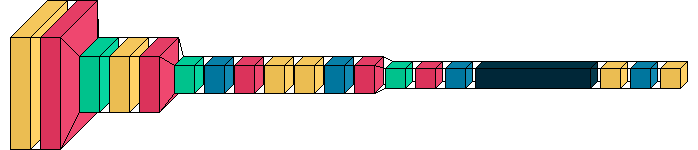

In [ ]:
visualkeras.layered_view(model)


Using Early Stopping to monitor the validation loss and stop the training when the loss begins to increase. Patience let's us set the number of epochs after which the training should be stopped in case of validation loss. We're setting it at 18.

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 18)


In [ ]:
model.fit(x = X_train, y = y_cat_train, batch_size = 128, epochs = 100, validation_data = (X_val, y_val), 
         callbacks = [early_stop])

Epoch 1/100
375/375 [==============================] - 5s 14ms/step - loss: 0.0888 - accuracy: 0.9670 - val_loss: 0.2496 - val_accuracy: 0.9252
Epoch 2/100
375/375 [==============================] - 5s 13ms/step - loss: 0.0869 - accuracy: 0.9680 - val_loss: 0.2485 - val_accuracy: 0.9268
Epoch 3/100
375/375 [==============================] - 5s 13ms/step - loss: 0.0830 - accuracy: 0.9687 - val_loss: 0.2561 - val_accuracy: 0.9256
Epoch 4/100
375/375 [==============================] - 5s 14ms/step - loss: 0.0828 - accuracy: 0.9693 - val_loss: 0.2440 - val_accuracy: 0.9282
Epoch 5/100
375/375 [==============================] - 5s 14ms/step - loss: 0.0822 - accuracy: 0.9689 - val_loss: 0.2568 - val_accuracy: 0.9255
Epoch 6/100
375/375 [==============================] - 5s 14ms/step - loss: 0.0812 - accuracy: 0.9702 - val_loss: 0.2820 - val_accuracy: 0.9207
Epoch 7/100
375/375 [==============================] - 5s 13ms/step - loss: 0.0787 - accuracy: 0.9701 - val_loss: 0.2749 - val_accuracy:

In [ ]:
metrics = pd.DataFrame(model.history.history)


In [ ]:
metrics.head()


,loss,accuracy,val_loss,val_accuracy
0,0.553630,0.799521,1.577726,0.530667
1,0.351147,0.872958,0.313563,0.880333
2,0.299054,0.889917,0.297108,0.892250
3,0.271959,0.901479,0.267093,0.903583
4,0.257155,0.905937,0.237631,0.915583


Plotting the loss and accuracy metrics



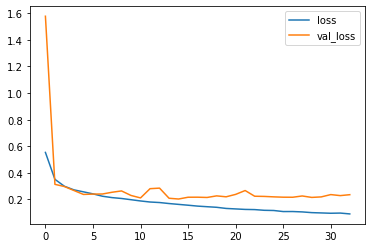

In [ ]:
metrics[['loss', 'val_loss']].plot()

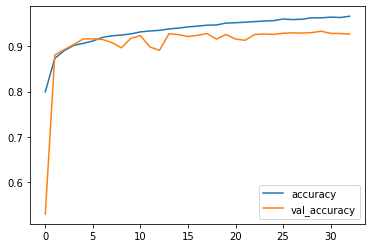

In [ ]:
metrics[['accuracy', 'val_accuracy']].plot()


Evaluating the model on the test set



In [ ]:
model.metrics_names


['loss', 'accuracy']

In [ ]:
model.evaluate(X_test, y_cat_test, verbose = 0)


[0.20651833713054657, 0.9344000220298767]

It has a **93.4%** accuracy on the test set which is not that bad. As you can see from the loss metric graph that the val_loss started to go up a little bit. To prevent that, you can apply some more regularizations in the neural network. You can reduce the patience level in Early stopping or use more dropout layers.



Let's visualize the true and predicted classes



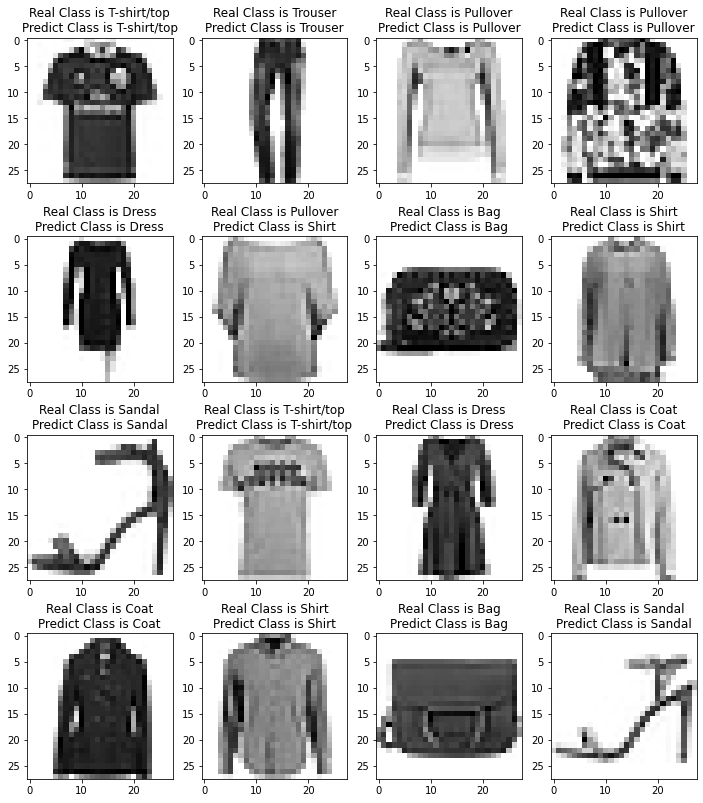

In [ ]:
predictions = model.predict(X_test)
X_test_reshape = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test_reshape[i], cmap='binary')
    ax.set(title = f"Real Class is {classes[y_cat_test[i].argmax()]}\nPredict Class is {classes[predictions[i].argmax()]}");


In [ ]:
predictions = model.predict(X_test)
# Convert predictions classes to one hot vectors 
predictions_classes = np.argmax(predictions, axis = 1)
# Convert test set observations to one hot vectors
y_true = np.argmax(y_cat_test, axis = 1)

In [ ]:
print(classification_report(y_true, predictions_classes))


              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.94      0.85      0.89      1000
           3       0.94      0.95      0.94      1000
           4       0.86      0.94      0.90      1000
           5       1.00      0.98      0.99      1000
           6       0.80      0.82      0.81      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.98      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.93      0.93     10000



Precision:- Precision is the number of positive class predictions that actually belong to the positive class.

Recall:- Recall is the number of positive class predictions made out of all positive examples in the dataset.

F1-score:- It provides a single score that balances both the concerns of precision and recall in one number.

In [ ]:
print(confusion_matrix(y_true, predictions_classes))


[[864   1  16  15   0   0 101   0   3   0]
 [  0 995   0   4   0   0   1   0   0   0]
 [ 12   0 846  10  77   0  54   0   1   0]
 [  7   3   3 946  28   0  13   0   0   0]
 [  1   0  11   9 943   0  36   0   0   0]
 [  0   0   0   0   1 977   0  16   1   5]
 [ 73   2  24  25  49   0 825   0   2   0]
 [  0   0   0   0   0   0   0 979   0  21]
 [  0   2   1   0   2   0   4   0 991   0]
 [  0   0   0   0   0   1   0  21   0 978]]


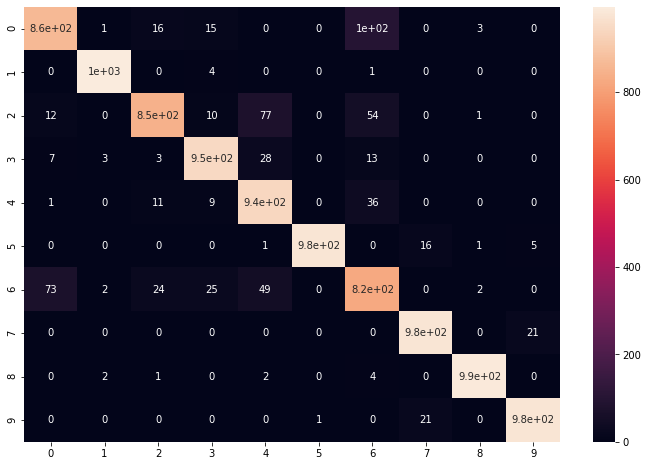

In [ ]:
plt.figure(figsize = (12, 8))
sns.heatmap(confusion_matrix(y_true, predictions_classes), annot=True)

Confusion Matrix:- It is a tabular summary of the number of correct and incorrect predictions made by a classifier.

